# Visualisation of embedding vectors
## Setup
 - BERT embeddings from a modified version of the pyp bert-embedding
 - Word2Vec from gensim

In [1]:
!pip install -e git+https://github.com/negedng/bert-embedding#egg=bert_embedding


Obtaining bert_embedding from git+https://github.com/negedng/bert-embedding#egg=bert_embedding
  Cloning https://github.com/negedng/bert-embedding to ./src/bert-embedding
  Running command git clone -q https://github.com/negedng/bert-embedding /content/src/bert-embedding
     |████████████████████████████████| 68.7MB 53kB/s 
     |████████████████████████████████| 256kB 46.9MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.9.1-cp36-cp36m-linux_x86_64.whl size=470981 sha256=b2601422fa839ae2e0efa2df3c5c3ba3ce760d374aeebffc969ef8b5e5037717
  Stored in directory: /root/.cache/pip/wheels/af/60/16/1f8a40e68b85bd9bd7960e91830bca5e40cd113f3220b7e231
Successfully built gluonnlp
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Running setup.py develop for bert-embedding


In [2]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-04-07 03:37:06--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.226.163
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.226.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  16.5MB/s    in 98s     

2020-04-07 03:38:45 (16.0 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
from gensim.models import KeyedVectors
WORD2WEC_EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(WORD2WEC_EMBEDDING_FILE, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding()


In [0]:
import numpy as np

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

## Word2Vec

Here we try to visualise the connection between the following words in a 2D subspace

In [0]:
Wl = ['man', 'woman', 'rich', 'poor', 'queen', 'king', 'fisherman', 'teacher', 'actress', 'actor']
Wv = []
for i in range(len(Wl)):
    Wv.append(word2vec[Wl[i]])

We want a subspace where the man-woman and the rich-poor are the axis lines, so these 4 words are on the corresponding axis

In [0]:
b1 = (Wv[1]-Wv[0])
b2 = (Wv[3]-Wv[2])

We want the basis to be the (1,0) and (0,1) of the projected space. With a squared matrix, we should compute the inverse matrix to get the basis vectors. However, the non-squared matrix has only pseudo-inverse.

In [0]:
W = np.array(Wv)
B = np.array([b1,b2])
Bi = np.linalg.pinv(B.T)

In [0]:
print(B.shape)
print(W.T.shape)

Project all the word embeddings to the 2D subspace.

 We have to shift the man-woman and rich-poor lines to the axis. 

In [0]:
Wp = np.matmul(Bi,W.T)
print(Wp.shape)
Wp = (Wp.T-[Wp[0,2],Wp[1,0]]).T

Let's plot the words!

In [0]:
plt.figure(figsize=(12,7))
plt.axvline()
plt.axhline()
plt.scatter(Wp[0,:], Wp[1,:])
rX = max(Wp[0,:])-min(Wp[0,:])
rY = max(Wp[1,:])-min(Wp[1,:])
eps = 0.005
for i, txt in enumerate(Wl):
    plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
plt.show()

## BERT
Here, we want to show the connection between the tokens of a sentence using the BERT embedding. We plot the tokens' embeddings in a subspace, where (0,1) and (1,0) are the [CLS] and [SEP] starter and ending tokens of the sentence.

In [0]:
s1 = "The sky is blue today."

In [0]:
embs = bert_embedding([s1], filter_spec_tokens=False)

In [0]:
labels = embs[0][0]
embV = embs[0][1]

Basis selected so the [CLS] and the [SEP] goes to (0,1) and (1,0)

In [0]:
W = np.array(embV)
B = np.array([embV[0], embV[-1]])
Bi = np.linalg.pinv(B.T)

In [0]:
print(W.shape)
print(Bi.shape)

(8, 768)
(2, 768)


Project the word tokens to the subspace

In [0]:
Wp = np.matmul(Bi,W.T)
print(Wp.shape)

(2, 8)


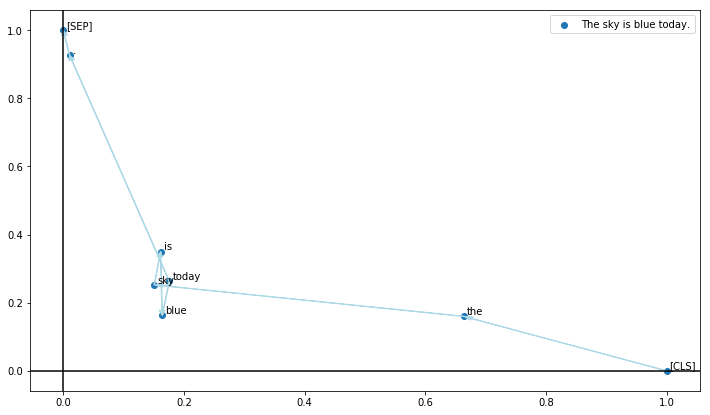

In [0]:
plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
plt.scatter(Wp[0,:], Wp[1,:], label=s1)
rX = max(Wp[0,:])-min(Wp[0,:])
rY = max(Wp[1,:])-min(Wp[1,:])
rM = max(rX, rY)
eps = 0.005
for i, txt in enumerate(labels):
    plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
    if i>0:
        plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color='lightblue', head_length=rM*eps*3, head_width=rM*eps*2, length_includes_head=True)
plt.legend()
plt.show()

Let's create a function with the previous steps to generate the plot-able coordinates from the sentences!

In [0]:
def get_visual_embs(sentence):
    """Get BERT embedding for the sentence,
    project it to a 2D subspace where [CLS] is (1,0) and [SEP] is (0,1)."""
    embs = bert_embedding([sentence], filter_spec_tokens=False)
    tokens = embs[0][0]
    embV = embs[0][1]
    W = np.array(embV)

    B = np.array([embV[0], embV[-1]])
    Bi = np.linalg.pinv(B.T)
    Wp = np.matmul(Bi,W.T)

    return Wp, tokens

### Sentence comparison
Okay, let's investigate on different sentences!

Let's change one word in the sentence!

['[CLS]', 'the', 'sky', 'is', 'blue', 'today', '.', '[SEP]']
['[CLS]', 'the', 'sea', 'is', 'blue', 'today', '.', '[SEP]']


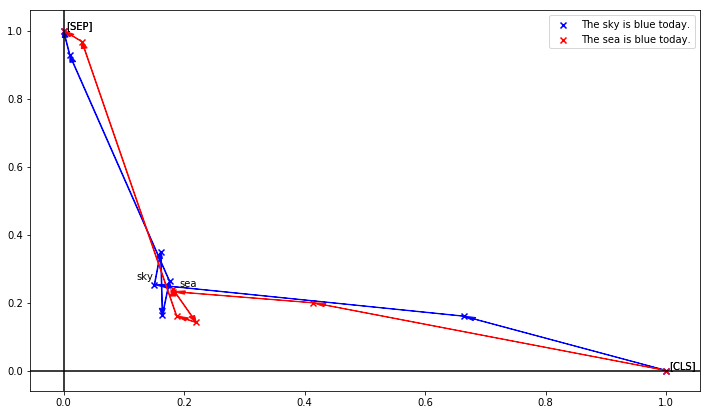

In [0]:
sentences = ['The sky is blue today.', 'The sea is blue today.']
colors = ['blue', 'red']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if txt == 'sky':
            plt.annotate(txt, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
        if txt == 'sea':
            plt.annotate(txt, (Wp[0,i]+rX*eps*2, Wp[1,i]+rX*eps*3))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

Now, let's change the tense of the sentence!

['[CLS]', 'this', 'is', 'a', 'horrible', 'idea', '!', '[SEP]']
['[CLS]', 'this', 'was', 'a', 'horrible', 'idea', '!', '[SEP]']
['[CLS]', 'this', 'will', 'be', 'a', 'horrible', 'idea', '!', '[SEP]']


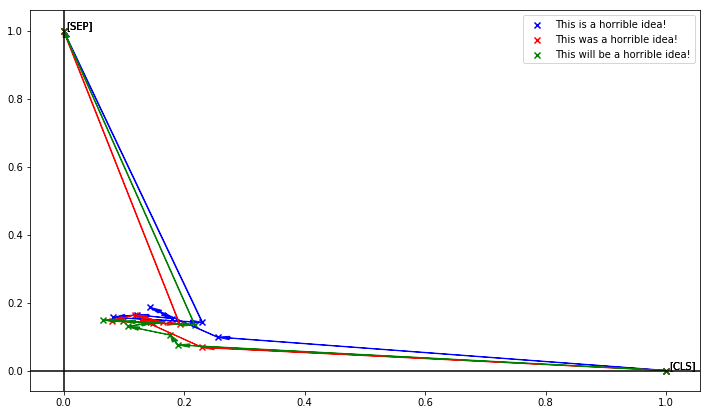

In [0]:
sentences = ['This is a horrible idea!', 'This was a horrible idea!', 'This will be a horrible idea!']
colors = ['blue', 'red', 'green']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        #plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

Punctuation characters?

['[CLS]', 'this', 'is', 'a', 'horrible', 'idea', '.', '[SEP]']
['[CLS]', 'this', 'is', 'a', 'horrible', 'idea', '!', '[SEP]']
['[CLS]', 'this', 'is', 'a', 'horrible', 'idea', '?', '[SEP]']


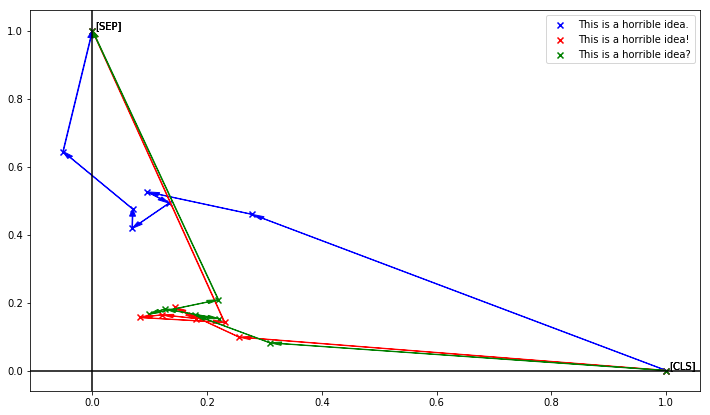

In [0]:
sentences = ['This is a horrible idea.', 'This is a horrible idea!', 'This is a horrible idea?']
colors = ['blue', 'red', 'green', 'yellow']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        #plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

Complex sentences with Mexico in it.

['[CLS]', 'in', 'mexico', 'the', 'national', 'government', 'is', 'carrying', 'out', 'a', 'consistent', 'policy', 'of', 'developing', 'its', 'railway', 'lines', '.', '[SEP]']
['[CLS]', 'borlaug', 'also', 'promoted', 'the', 'process', '(', 'which', 'proved', 'wildly', 'successful', ')', 'of', 'having', 'two', 'wheat', '-', 'growing', 'seasons', 'in', 'mexico', '[SEP]']
['[CLS]', 'that', "'", 's', 'in', 'mexico', ',', 'too', '.', '[SEP]']
['[CLS]', 'in', '1904', 'he', 'went', 'to', 'japan', 'as', 'war', 'correspondent', 'and', 'in', '1914', 'to', 'mexico', 'in', 'the', 'same', 'capacity', '.', '[SEP]']


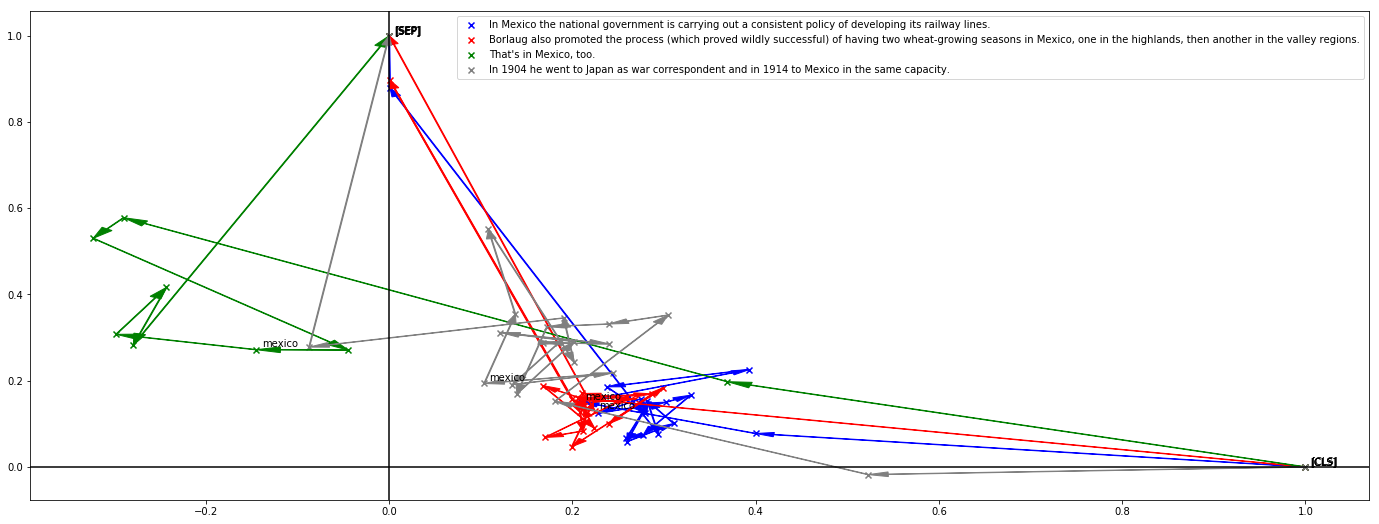

In [0]:
# Some sentences from here: https://sentence.yourdictionary.com/mexico
sentences = ["In Mexico the national government is carrying out a consistent policy of developing its railway lines.", 
             "Borlaug also promoted the process (which proved wildly successful) of having two wheat-growing seasons in Mexico, one in the highlands, then another in the valley regions.",
             "That's in Mexico, too.",
             "In 1904 he went to Japan as war correspondent and in 1914 to Mexico in the same capacity."]
colors = ['blue', 'red', 'green', 'grey', 'purple', 'orange', 'lightblue', 'yellow']

plt.figure(figsize=(24,9))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if txt=='mexico':
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

Reactions, dialogue

['[CLS]', 'yes', ',', 'that', "'", 's', 'true', '!', '[SEP]']
['[CLS]', 'of', 'course', ',', 'he', 'is', 'successful', '.', '[SEP]']
['[CLS]', 'no', ',', 'did', 'you', '?', '[SEP]']
['[CLS]', 'i', 'can', 'totally', 'agree', 'with', 'that', '.', '[SEP]']
['[CLS]', 'however', ',', 'it', 'can', "'", 't', 'be', 'seen', '.', '[SEP]']


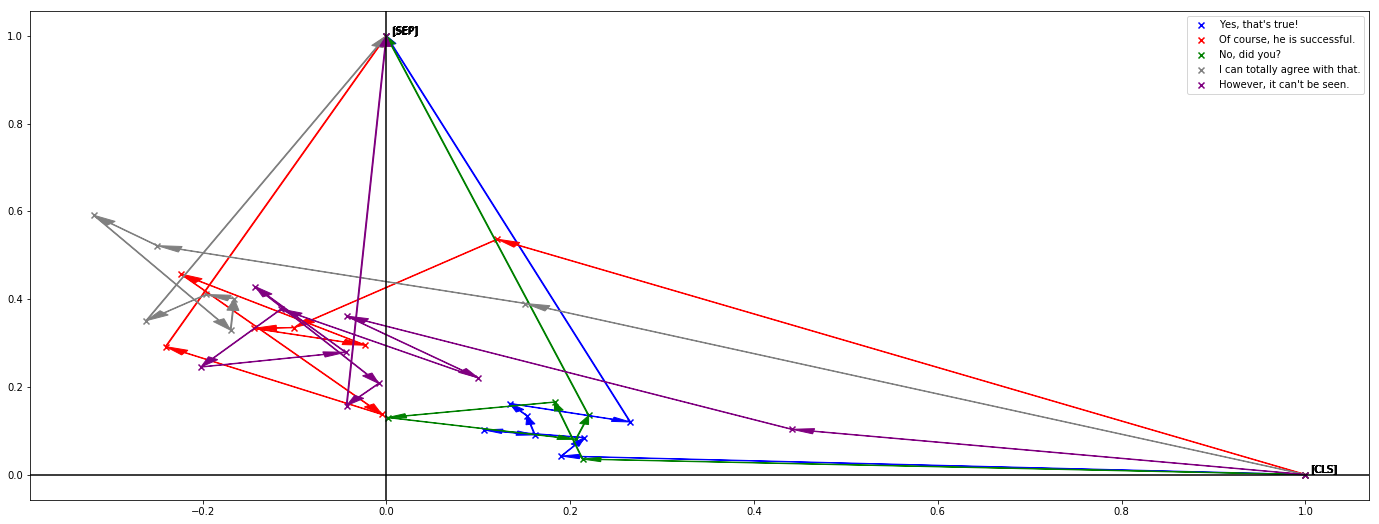

In [0]:
# Some sentences from here: https://sentence.yourdictionary.com/mexico
sentences = ["Yes, that's true!", 
             "Of course, he is successful.",
             "No, did you?",
             "I can totally agree with that.",
             "However, it can't be seen.",]
colors = ['blue', 'red', 'green', 'grey', 'purple', 'orange', 'lightblue', 'yellow']

plt.figure(figsize=(24,9))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

Non-real sentences

['[CLS]', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', '[SEP]']
['[CLS]', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '[SEP]']
['[CLS]', 'gre', 'htrha', 'hthateh', 'heta', 'ger', 'er', '[SEP]']
['[CLS]', 'the', 'sky', 'is', 'blue', 'today', '.', '[SEP]']
['[CLS]', 'james', 'cook', 'was', 'a', 'very', 'good', 'man', 'and', 'a', 'loving', 'husband', '.', '[SEP]']


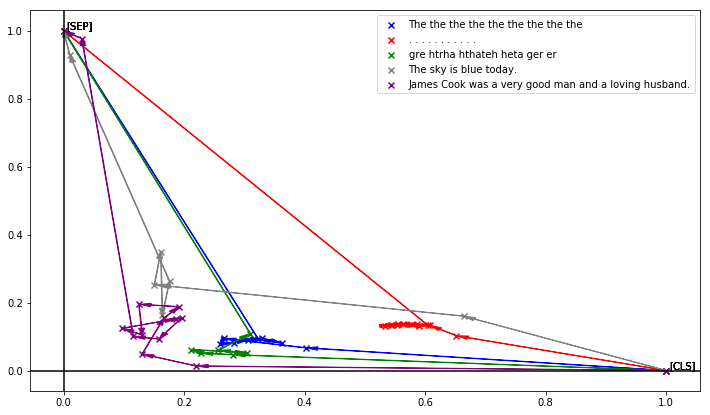

In [0]:
# Some sentences from here: https://sentence.yourdictionary.com/mexico
sentences = ["The the the the the the the the the", 
             ". . . . . . . . . . .",
             "gre htrha hthateh heta ger er",
             "The sky is blue today.",
             "James Cook was a very good man and a loving husband."]
colors = ['blue', 'red', 'green', 'grey', 'purple', 'orange', 'lightblue', 'yellow']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()